### Malaria Detection: Deep Learning with Computer Vision

###<b>Loading libraries</b>

In [2]:
#!pip install tensorflow

In [3]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import aws packages
import sagemaker
import boto3

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

Matplotlib is building the font cache; this may take a moment.


### <b>Let us load the data</b>

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [4]:
#buckets created manuallly in s3 and unzippped prior to this step
bucket = 'kdfdlkfasdklfjaslkdfjkalsdjfdasklflakdjflks'
train_dir = 'train' #prefix for the training directory

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

from sagemaker import get_execution_role
sagemaker_session = sagemaker.Session()
role = get_execution_role()
#print(role) - check role and change policy is getting access denied error

#set up the connection to s3 bucket
conn = boto3.client('s3') #limits to pulling 1,000 files, need multiple calls to API
paginator = conn.get_paginator('list_objects') #make multiple calls

#additional prefixes within the training directory
for folder_name in ['/parasitized/', '/uninfected/']:

    #initialize key list
    key_list = [ ]

    #Path of the folder
    contents = paginator.paginate(Bucket=bucket, Prefix=train_dir+folder_name).build_full_result()['Contents'] #extract list of images
    for f in contents:
        key_list.append(f['Key'])
    
    #access images from list, skip over first two keys which are "directories"
    #skipped over directories: 'unzipped/cell_images/train/', 'unzipped/cell_images/train/parasitized/'
    for i, key in enumerate(key_list):
        try:
            s3_object = conn.get_object(Bucket=bucket, Key=key)
            body = s3_object['Body']
            image = Image.open(body)
            image = image.resize((SIZE, SIZE))
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [5]:
#buckets created manuallly in s3 and unzippped prior to this step
bucket = 'kdfdlkfasdklfjaslkdfjkalsdjfdasklflakdjflks'
test_dir = 'test' #prefix for the training directory

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
test_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
test_labels = []

from sagemaker import get_execution_role
sagemaker_session = sagemaker.Session()
role = get_execution_role()
#print(role) - check role and change policy is getting access denied error

#set up the connection to s3 bucket
conn = boto3.client('s3') #limits to pulling 1,000 files, need multiple calls to API
paginator = conn.get_paginator('list_objects') #make multiple calls

#additional prefixes within the training directory
for folder_name in ['/parasitized/', '/uninfected/']:

    #initialize key list
    key_list = [ ]

    #Path of the folder
    contents = paginator.paginate(Bucket=bucket, Prefix=test_dir+folder_name).build_full_result()['Contents'] #extract list of images
    for f in contents:
        key_list.append(f['Key'])
    
    #access images from list, skip over first two keys which are "directories"
    #skipped over directories: 'unzipped/cell_images/train/', 'unzipped/cell_images/train/parasitized/'
    for i, key in enumerate(key_list):
        try:
            s3_object = conn.get_object(Bucket=bucket, Key=key)
            body = s3_object['Body']
            image = Image.open(body)
            image = image.resize((SIZE, SIZE))
            test_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b> Checking the shape of train and test images

In [6]:
print(train_images.shape)
print(test_images.shape)

(24958, 64, 64, 3)
(2600, 64, 64, 3)


###<b> Checking the shape of train and test labels

In [7]:
print(train_labels.shape)
print(test_labels.shape)

(24958,)
(2600,)


#####<b> Observations and insights: There are nearly 25,000 labels in the training dataset and 2,600 labels in the test dataset.

### <b>Check the minimum and maximum range of pixel values for train and test images

In [8]:
print(np.amax(train_images))
print(np.amin(train_images))
print(np.amax(train_images))
print(np.amin(train_images))

255
0
255
0


#####<b> Observations and insights: The minimum and maximum are 0 and 255 respectively for both the training and testing datasets.

### Count the number of values in both uninfected and parasitized

In [9]:
# try to use value_counts to count the values
unique, counts = np.unique(test_labels, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1300, 1: 1300}
{0: 12376, 1: 12582}


###<b>Normalize the images

In [10]:
train_images = (train_images/255).astype('float32')
test_images = (test_images/255).astype('float32')

As we have done our preprocessing required and performed some EDA to gain some insights in our Milestone-1 so now we will try to build our model and try evaluating its performance.

###<b> Plot to check if the data is balanced

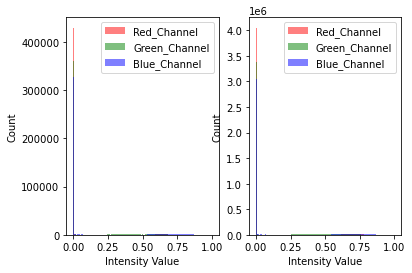

In [11]:
plt.subplot(1, 2, 1)
plt.hist(test_images[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
plt.hist(test_images[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
plt.hist(test_images[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.subplot(1, 2, 2)
plt.hist(train_images[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
plt.hist(train_images[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
plt.hist(train_images[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
plt.xlabel('Intensity Value')
plt.ylabel('Count')
plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

#### Observations and insights: The distributions of the pixels in each of the red, green and blue channels are similar between the training and test dataset.

### <b>Data Exploration</b>
Let's visualize the images from the train data

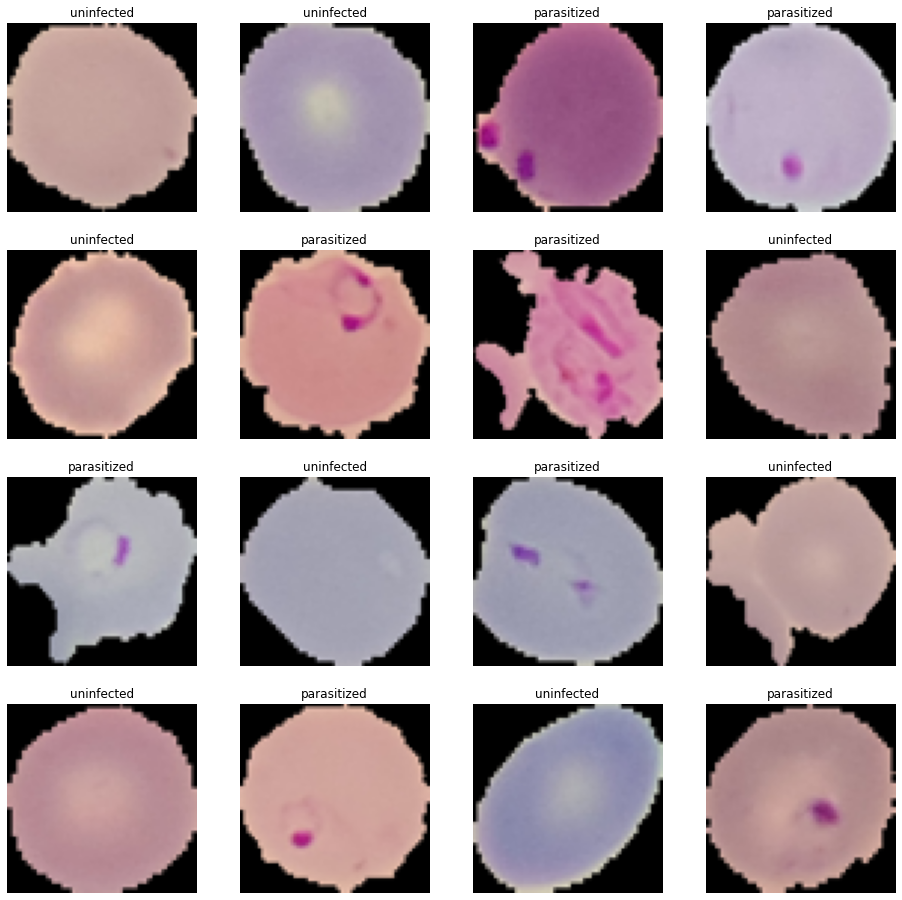

In [12]:
# This code will help you in visualizing both the parasitized and uninfected images
np.random.seed(42)
plt.figure(1 , figsize = (16 , 16))

for n in range(1, 17):
    plt.subplot(4, 4, n)
    index = int(np.random.randint(0, train_images.shape[0], 1))
    if train_labels[index] == 1: 
        plt.title('parasitized')
    else:
        plt.title('uninfected')
    plt.imshow(train_images[index])
    plt.axis('off')

##### Observations and insights: The parasitized cells appear to have dots on the cells, whereas the other cells do not.

###<B>One Hot Encoding on the train and test labels

In [13]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

####<b> Importing the required libraries

In [14]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the model

In [15]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4128      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4

####<b> Compiling the model

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks 

In [17]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train our Model

In [18]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history=model.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 14s 22ms/step - loss: 0.4124 - accuracy: 0.8081 - val_loss: 0.2427 - val_accuracy: 0.8988
Epoch 2/20
624/624 [==============================] - 13s 21ms/step - loss: 0.1199 - accuracy: 0.9546 - val_loss: 0.2421 - val_accuracy: 0.9269
Epoch 3/20
624/624 [==============================] - 13s 21ms/step - loss: 0.0927 - accuracy: 0.9680 - val_loss: 0.1285 - val_accuracy: 0.9692
Epoch 4/20
624/624 [==============================] - 13s 22ms/step - loss: 0.0747 - accuracy: 0.9754 - val_loss: 0.1034 - val_accuracy: 0.9760
Epoch 5/20
624/624 [==============================] - 13s 21ms/step - loss: 0.0702 - accuracy: 0.9764 - val_loss: 0.0971 - val_accuracy: 0.9802
Epoch 6/20
624/624 [==============================] - 13s 21ms/step - loss: 0.0678 - accuracy: 0.9777 - val_loss: 0.1051 - val_accuracy: 0.9742
Epoch 7/20
624/624 [==============================] - 13s 21ms/step - loss: 0.0623 - accuracy: 0.9796 - val_loss: 0.1072 - val_accuracy:

####<b> Evaluating the model on test data

In [19]:
accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 1s 6ms/step - loss: 0.0817 - accuracy: 0.9777

 Test_Accuracy:- 0.9776923060417175


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



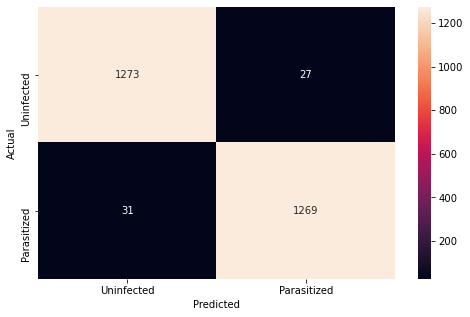

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b>Plotting the train and validation curves

In [21]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

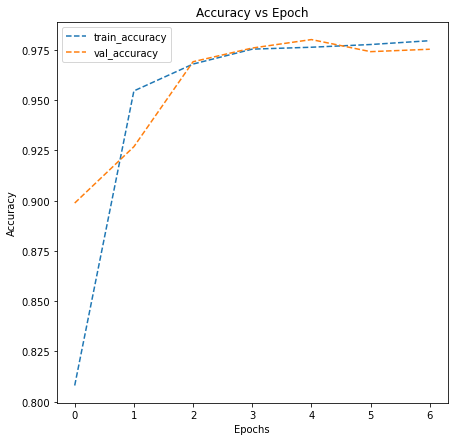

In [22]:
plot_accuracy(history)



* Here we can clearly observe that the training and valiation accuracy are increasing 
* And we can also notice that validation accuracy is slightly higher than the train accuracy

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [23]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model
    
    

In [24]:
#creating sequential model
model1=Sequential()

model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(Conv2D(filters=32,kernel_size=3,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(2,activation="softmax"))#2 represent output layer neurons 


model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        9

####<b> Compiling the model

The loss function of binary_crossentropy seemed reasonable, since we are aiming to classify cells into two categories (infected vs. uninfected). Selection of the loss function will be based on the type of classification task. RMSprop optimizer was selected; it uses the sign of the gradient to determine the extent to which to increase the step size. If the signs agree, then the step size is increased in updating the weights. This works with batches as compared to Rprop.
 
Documentation for loss functions: https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function 
Documentation for the optimizers: https://keras.io/api/optimizers/

In [25]:
#model2.compile(loss=tf.keras.losses.KLDivergence(reduction="auto", name="kl_divergence"), optimizer='RMSprop', metrics=['accuracy'])
model1.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

<b> Using Callbacks
 

In [26]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [27]:
history1=model1.fit(train_images,train_labels,batch_size=32,callbacks=callbacks, validation_split=0.2,epochs=30,verbose=1)

Epoch 1/30
624/624 [==============================] - 33s 52ms/step - loss: 0.3134 - accuracy: 0.8442 - val_loss: 0.1689 - val_accuracy: 0.9750
Epoch 2/30
624/624 [==============================] - 32s 51ms/step - loss: 0.0964 - accuracy: 0.9737 - val_loss: 0.1977 - val_accuracy: 0.9581
Epoch 3/30
624/624 [==============================] - 32s 51ms/step - loss: 0.0861 - accuracy: 0.9753 - val_loss: 0.1689 - val_accuracy: 0.9720
Epoch 4/30
624/624 [==============================] - 32s 51ms/step - loss: 0.0841 - accuracy: 0.9756 - val_loss: 0.1555 - val_accuracy: 0.9724
Epoch 5/30
624/624 [==============================] - 32s 51ms/step - loss: 0.0850 - accuracy: 0.9762 - val_loss: 0.1039 - val_accuracy: 0.9784
Epoch 6/30
624/624 [==============================] - 32s 51ms/step - loss: 0.0828 - accuracy: 0.9760 - val_loss: 0.0968 - val_accuracy: 0.9794
Epoch 7/30
624/624 [==============================] - 32s 51ms/step - loss: 0.0799 - accuracy: 0.9771 - val_loss: 0.1436 - val_accuracy:

####<b> Evaluating the model

In [28]:
accuracy1 = model1.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 1s 11ms/step - loss: 0.1473 - accuracy: 0.9769

 Test_Accuracy:- 0.9769230484962463


<b> Plotting the confusion matrix
    
The primary 
   

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1300
           1       0.99      0.96      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



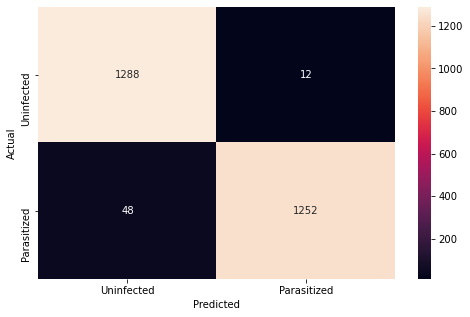

In [29]:
pred = model1.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Plotting the Train and validation curves

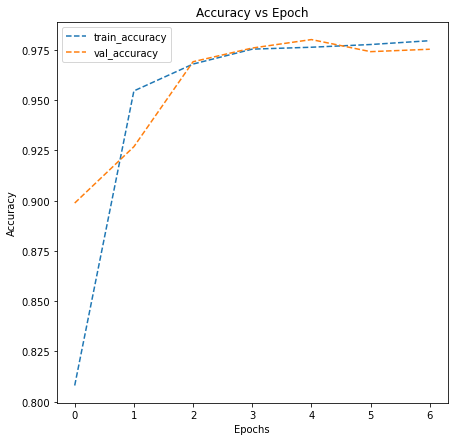

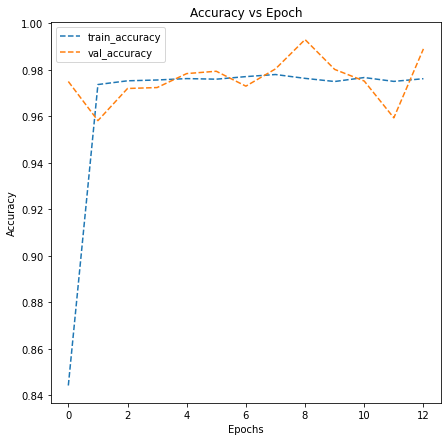

In [30]:
plot_accuracy(history)
plot_accuracy(history1)

####<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?

LeakyRelu is likely to improve the performance compared to the Relu activation function, since it allows a small, non-zero constant gradient to avoid the dying relu problem.

*  Can BatchNormalization improve our model?

Batch normalization may improve the model since the covariates may shift less numerically in the network between layers; this speeds up training and allows use of a higher learning rate.
The training will show down when moving from the Relu to LeakyRelu, but Batch Normalization will hopefully aid in offsetting this slow down?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [31]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [32]:
model2 = Sequential()
model2.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding='same'))
model2.add(BatchNormalization())

model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU(),input_shape=(64,64,3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=3,padding="same",activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(Flatten())

model2.add(BatchNormalization())
model2.add(Dense(512,activation=keras.layers.LeakyReLU()))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(BatchNormalization())
model2.add(Dense(2,activation="softmax"))#2 represent output layer neurons 

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0

####<b>Compiling the model

In [33]:
model2.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

<b> Using callbacks

In [34]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and train the model
    
 Addition of the LeakRelu function and the batch normalization increased the runtime from 30s to ~150s.

In [35]:
history2 = model2.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=30,verbose=1)

Epoch 1/30
624/624 [==============================] - 98s 154ms/step - loss: 0.2309 - accuracy: 0.9140 - val_loss: 0.0868 - val_accuracy: 0.9758
Epoch 2/30
624/624 [==============================] - 95s 152ms/step - loss: 0.0873 - accuracy: 0.9722 - val_loss: 0.0961 - val_accuracy: 0.9671
Epoch 3/30
624/624 [==============================] - 95s 153ms/step - loss: 0.0746 - accuracy: 0.9772 - val_loss: 0.0767 - val_accuracy: 0.9768
Epoch 4/30
624/624 [==============================] - 95s 152ms/step - loss: 0.0705 - accuracy: 0.9776 - val_loss: 0.0339 - val_accuracy: 0.9872
Epoch 5/30
624/624 [==============================] - 95s 153ms/step - loss: 0.0630 - accuracy: 0.9781 - val_loss: 0.0957 - val_accuracy: 0.9675
Epoch 6/30
624/624 [==============================] - 95s 153ms/step - loss: 0.0627 - accuracy: 0.9788 - val_loss: 0.0405 - val_accuracy: 0.9840
Epoch 7/30
624/624 [==============================] - 96s 153ms/step - loss: 0.0601 - accuracy: 0.9810 - val_loss: 0.0398 - val_ac

<b>Plotting the train and validation accuracy

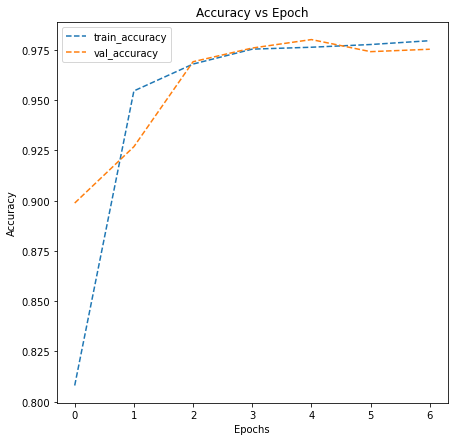

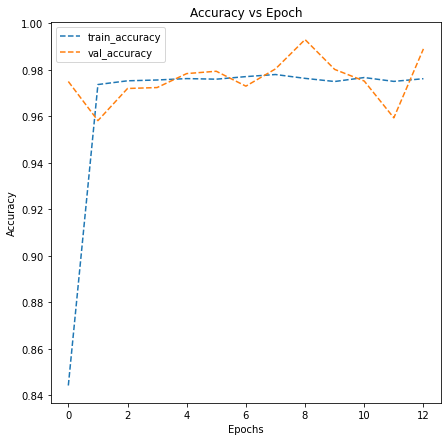

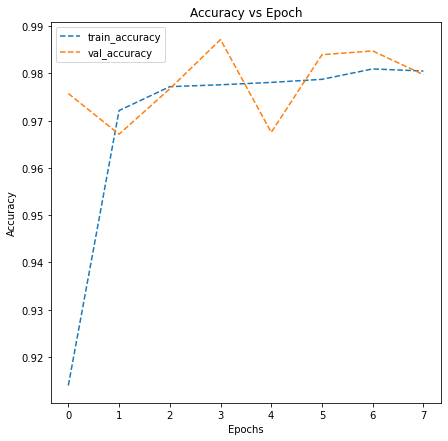

In [36]:
plot_accuracy(history)
plot_accuracy(history1)
plot_accuracy(history2)

####<b>Evaluating the model

In [37]:
accuracy2 = model2.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 2s 21ms/step - loss: 0.0531 - accuracy: 0.9804

 Test_Accuracy:- 0.9769230484962463


##### Observations and insights: The validation accuracy is a bit unstable and shows some evidence of overfitting around the 8th epoch.

<b> Generate the classification report and confusion matrix 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



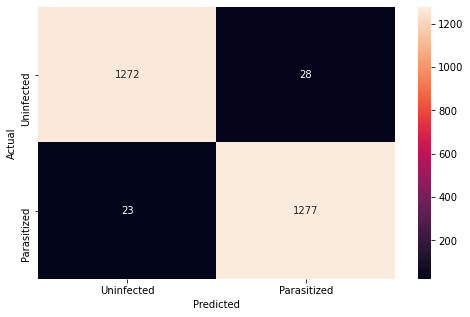

In [38]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model2.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [39]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Using image data generator

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images

train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                  zoom_range = 0.5, rotation_range=30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size=64, seed=42, shuffle=True)     

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x= X_val, y = y_val, batch_size=64, seed=42, shuffle=True)

####**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.

1. First, started off with a horizontal flip augmentation, where some of the images are randomly horizontally flipped.



####<B>Visualizing Augmented images

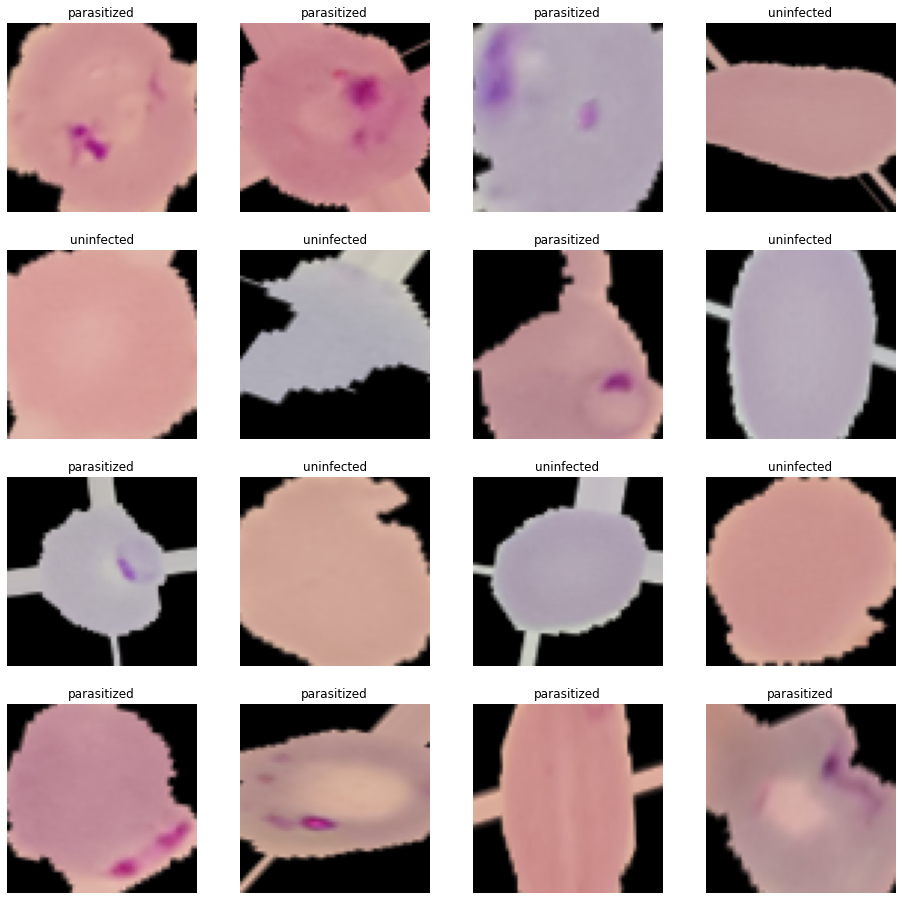

In [41]:
#Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

Observations and insights: Some of the images are horizontally flipped or augmented.

####<b>Building the Model

In [42]:
model3 = model2 
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0

<b>Using Callbacks

In [43]:
callbacks = [EarlyStopping(monitor='val_loss', patience=4),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [44]:
history3 = model3.fit(train_generator, 
                                  validation_data=val_generator,
                                  batch_size=32,callbacks=callbacks,
                                  epochs=20,verbose=1)

Epoch 1/20
312/312 [==============================] - 94s 296ms/step - loss: 0.1512 - accuracy: 0.9508 - val_loss: 0.0674 - val_accuracy: 0.9728
Epoch 2/20
312/312 [==============================] - 91s 291ms/step - loss: 0.1356 - accuracy: 0.9544 - val_loss: 0.0624 - val_accuracy: 0.9800
Epoch 3/20
312/312 [==============================] - 91s 291ms/step - loss: 0.1317 - accuracy: 0.9546 - val_loss: 0.0506 - val_accuracy: 0.9828
Epoch 4/20
312/312 [==============================] - 91s 290ms/step - loss: 0.1275 - accuracy: 0.9568 - val_loss: 0.0521 - val_accuracy: 0.9822
Epoch 5/20
312/312 [==============================] - 91s 292ms/step - loss: 0.1202 - accuracy: 0.9584 - val_loss: 0.0524 - val_accuracy: 0.9814
Epoch 6/20
312/312 [==============================] - 91s 290ms/step - loss: 0.1253 - accuracy: 0.9572 - val_loss: 0.0478 - val_accuracy: 0.9820
Epoch 7/20
312/312 [==============================] - 91s 292ms/step - loss: 0.1251 - accuracy: 0.9573 - val_loss: 0.0540 - val_ac

####<B>Evaluating the model

<b>Plot the train and validation accuracy


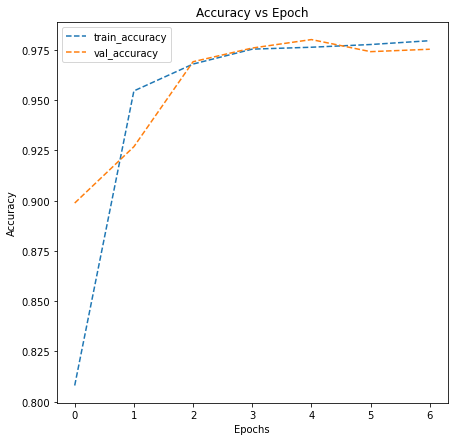

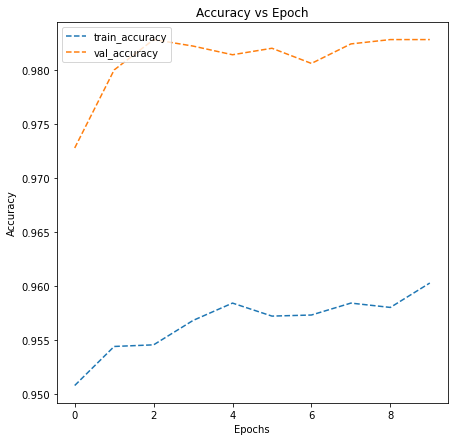

In [45]:
plot_accuracy(history)
plot_accuracy(history3)

In [46]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 2s 21ms/step - loss: 0.0394 - accuracy: 0.9862

 Test_Accuracy:- 0.9861538410186768


<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1300
           1       0.98      0.99      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



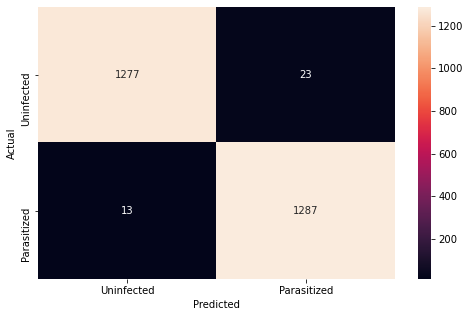

In [47]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model3.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on our data.

### **Pre-trained model (VGG16)**

In [48]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [49]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [50]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

# Add classification layers on top of it  
 
x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation='relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)

# Add a dense layer with 2 neurons 
x = BatchNormalization()(x)
pred = Dense(2, activation='softmax')(x)

model4 = Model(vgg.input, pred) #Initializing the model

####<b>Compiling the model

In [51]:
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> using callbacks

In [52]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [53]:
#Fitting the model and running the model for 10 epochs
history4 = model4.fit(train_generator, 
                                  validation_data=val_generator,
                                  batch_size=32,callbacks=callbacks,
                                  epochs=10,verbose=1)

Epoch 1/10
312/312 [==============================] - 71s 227ms/step - loss: 0.3642 - accuracy: 0.8487 - val_loss: 0.2335 - val_accuracy: 0.9213
Epoch 2/10
312/312 [==============================] - 70s 226ms/step - loss: 0.3133 - accuracy: 0.8701 - val_loss: 0.1927 - val_accuracy: 0.9283
Epoch 3/10
312/312 [==============================] - 71s 227ms/step - loss: 0.3003 - accuracy: 0.8751 - val_loss: 0.2013 - val_accuracy: 0.9253
Epoch 4/10
312/312 [==============================] - 71s 226ms/step - loss: 0.2977 - accuracy: 0.8778 - val_loss: 0.2506 - val_accuracy: 0.9042


<b>Plot the train and validation accuracy

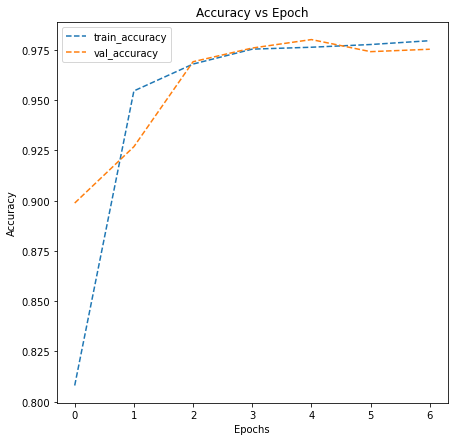

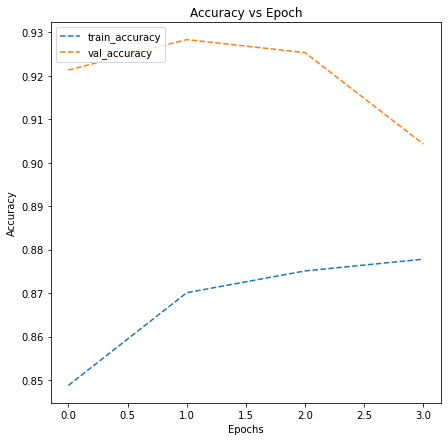

In [54]:
plot_accuracy(history)
plot_accuracy(history4)

VGG16 had worse performance than the model constructed in this notebook; validation accuracy hovered between 90-92%, whereas the trest accuracy was at approximately 88%.

####<b> Evaluating the model

In [55]:
accuracy4 = model4.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy4[1])

82/82 [==============================] - 7s 88ms/step - loss: 0.2807 - accuracy: 0.8765

 Test_Accuracy:- 0.8765384554862976


<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1300
           1       0.82      0.96      0.89      1300

    accuracy                           0.88      2600
   macro avg       0.89      0.88      0.88      2600
weighted avg       0.89      0.88      0.88      2600



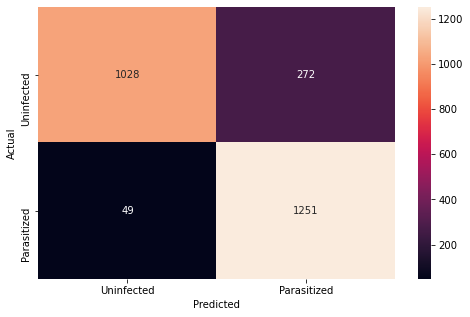

In [56]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model4.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

####<b>Think about it:</b>

For uninfected cells, 81% of predicted uninfected cells are actually uninfected. 99% of uninfected cells were predicted as uninfected.
For infected cells, 99% of predicted infected cells are actually infected. 76% of infected cells were predicted as infected.


Observations and Conclusions drawn from the final model: The final is model 3 performed very well with overall accuracy around 99%, with nearly equivalent recall and precision regardless of uninfected or infected status.



**Improvements that can be done:**<br>


*  Can the model performance be improved using other pre-trained models or different CNN architecture?
*  You can try to build a model using these HSV images and compare them with your other models.

#### Print feature map for the augmented dataset

[<keras.layers.convolutional.Conv2D object at 0x7ff7965d1400>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff79642ff60>, <keras.layers.convolutional.Conv2D object at 0x7ff79921b5c0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff79921b6a0>, <keras.layers.pooling.MaxPooling2D object at 0x7ff79931efd0>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff79921d898>, <keras.layers.core.Dropout object at 0x7ff79921d5f8>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff799722588>, <keras.layers.convolutional.Conv2D object at 0x7ff79935e320>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff79935ebe0>, <keras.layers.convolutional.Conv2D object at 0x7ff7991f4a58>, <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff7991f4b38>, <keras.layers.convolutional.Conv2D object at 0x7ff7993702e8>, <keras.la

<Figure size 576x576 with 0 Axes>

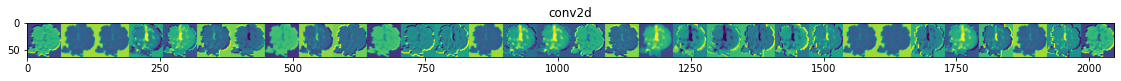

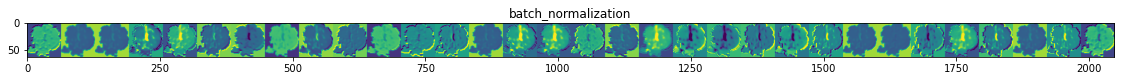

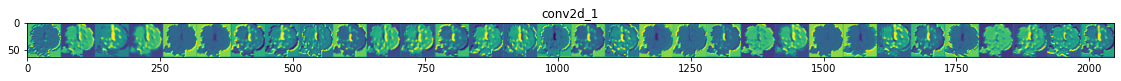

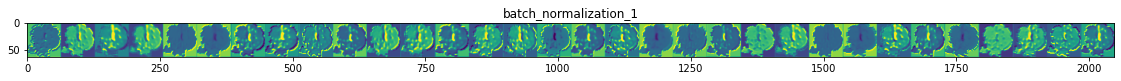

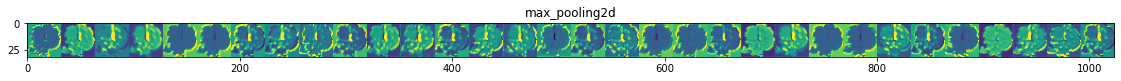

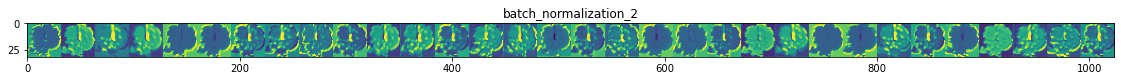

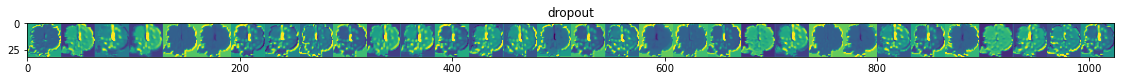

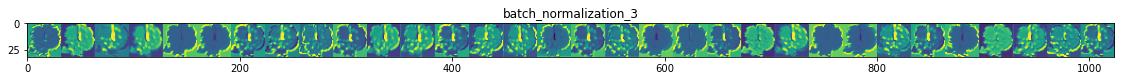

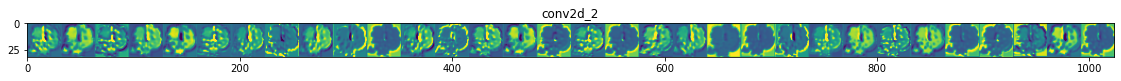

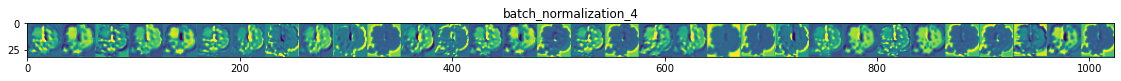

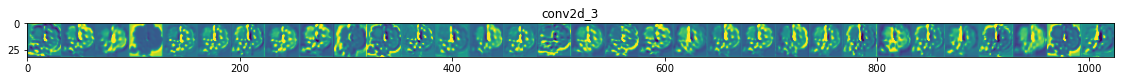

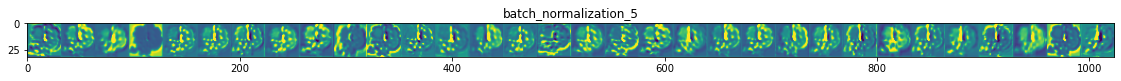

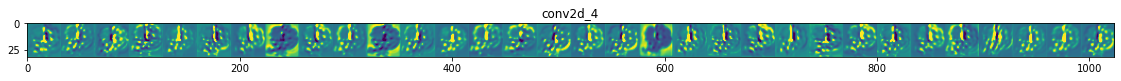

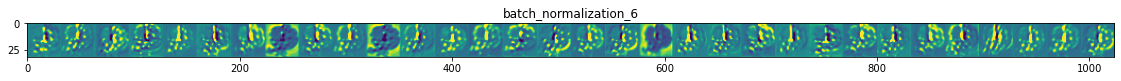

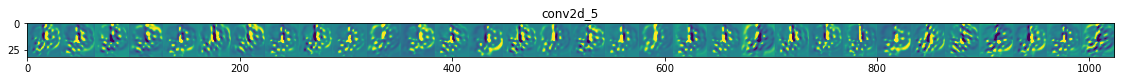

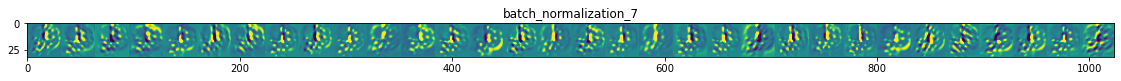

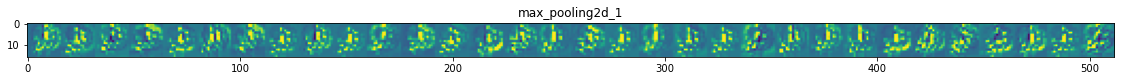

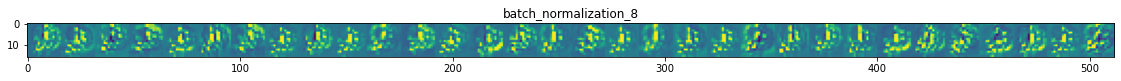

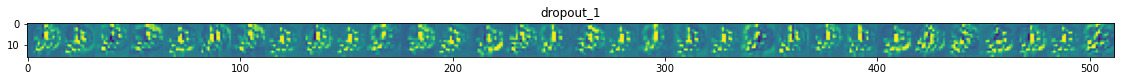

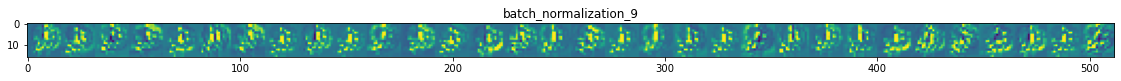

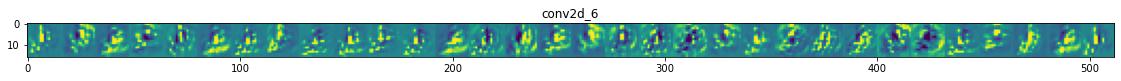

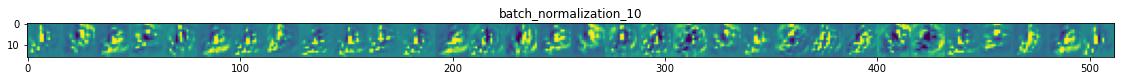

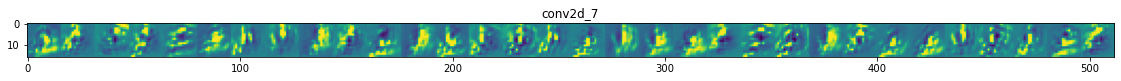

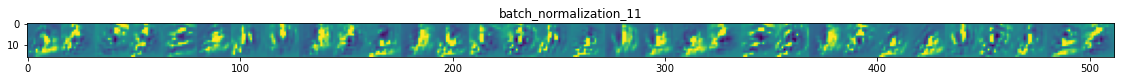

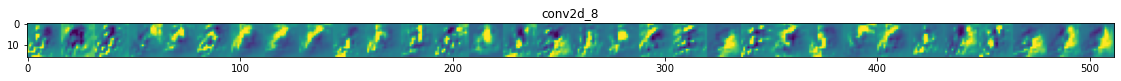

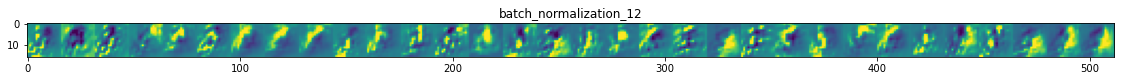

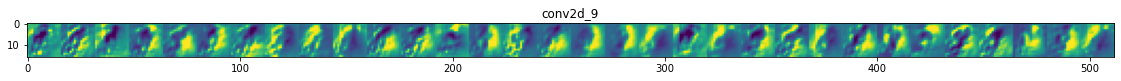

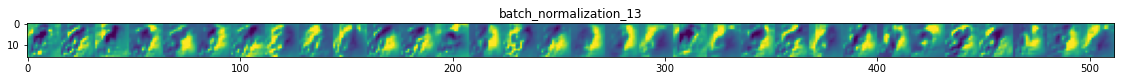

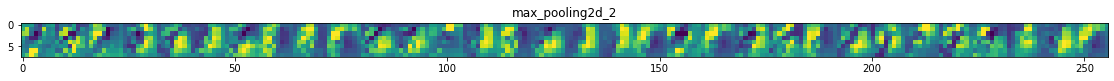

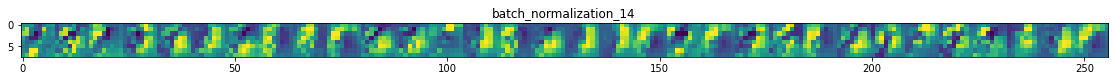

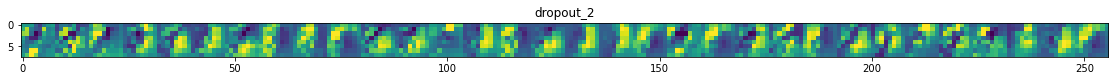

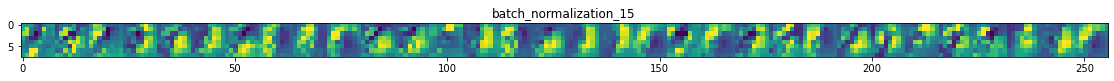

In [57]:
layer_names = [layer.name for layer in model3.layers]
layer_outputs = [layer.output for layer in model3.layers]
feature_map_model = tf.keras.models.Model(model3.input, layer_outputs)

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

resized_image = tf.reshape(train_images[100], shape=[1,64,64,3])
feature_maps = feature_map_model.predict(resized_image)


print(model3.layers)
for layer_name, feature_map in zip(layer_names, feature_maps):print(f"The shape of the {layer_name} is =======>> {feature_map.shape}")

imagebelt=[]
fig = plt.figure(figsize=(8, 8))
for layer_name, feature_map in zip(layer_names, feature_maps):   
    if len(feature_map.shape) == 4:
        channels=feature_map.shape[-1]
        size=feature_map.shape[1]
        imagebelt=np.zeros((size,size*channels))
        for i in range(channels):
            feature_image = feature_map[0, :, :, i]
            feature_image-= feature_image.mean()
            feature_image/= feature_image.std ()
            feature_image*=  64
            feature_image+= 128
            feature_image= np.clip(feature_image, 0, 255).astype('uint8')
            imagebelt[:,i * size : (i + 1) * size] = feature_image 
            
            scale = 20./ channels
        plt.figure(figsize=(scale * channels, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow(imagebelt)

### **Insights**

**Refined insights**:
- What are the most meaningful insights from the data relevant to the problem?

It is pretty challenging to interpret this convolutional neural network; this notebook visualized filters and feature maps  towards the end of this notebook to show how the neural network is detecting the edge or the shape of the cells and uses that information in classification; also in the early layers, it appears that the convolutional neural network is detecting dark splotches on infected cells that may indicate damage to the cell? This information about the edges and shape of the cell are abstracted to less discernable features towards the end of the network.

**Comparison of various techniques and their relative performance**:
- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

**Alternative Activation Functions:** Relu activation function converges faster than sigmoid and other functions, but also faster than the Leaky Relu but the training speed is more similar to each other; both the Relu and the Leaky Relu functions keeps positive values and kills gradient for negative values. Some relu activation functions may not activate; if the learning rate is too high, the weights may jump and the relu may die during training. To minimize the loss of dead Relu functions, leaky relu can help address this concern, since negative values are assigned a slight slope and not automatically set to 0 like Relu. 

**Batch Normalization:** Instead of weight initialization, batch normalization sets gaussian distribution at each layer, we can normalize each neuron and calculate mean and variance for each layer for each batch. Batch normalization facilitates training, allows higher learning rates, reduces dependence of the result on the initialization, and regularizes results. 

**Drop-Out:** Avoided overfitting by using drop-out and hopefully retains more robust features by reducing reliance on identifying a single feature or overfitting by learning and unlearning the same feature through co-adaptation.

**Data Augmentation:** Data augmentation helped distinguish model 3 from the base model; it was not until data augmentation was added that model 3 began outperforming the base model. Prior to data augmentation, the base model was performing similarly to model 3. The pre-trained model from ImageNet did not appear to outperform either the base model or model 3 using the augmented data.

**Proposal for the final solution design**:
- What model do you propose to be adopted? Why is this the best solution to adopt?

Model 3 was the best performing model in terms of overall accuracy, precision, f1 and recall regardless of classifyign infected versus uninfected cells. This approach avoided overfitting, where the overall accuracy of the validation set was ~99% compared to the base model with overall accuracy in the validation set around ~97%. This model was more precise and more sensitive to detecting malaria than the base model. This model differed from the base model, since it had greater depth (more layers), utilized leaky relu activation functions, utilized batch normalization prior to each convolutional layer, utilized drop-out and optimized using RMSprop as compared to adam. Binary cross-entropy optimizer was kept for all models, since the task was to class cells as either infected or no infected by malaria, which is binary. 